## Introduction

Photography has long been regarded as a form of art. Assessing the aesthetic value of a picture
is therefore entirely subjective and personal. Nowadays, people capture millions of photos every
day, and either hopes to share the best photo on social networks or endeavor to create a piece of
art. Flushing photo streams make selecting the best photo from gallery has become more and more
time-consuming and arduous. 

To have a brief idea about aesthetics, There are examples pictures of architectural facades. Although each image features the same basic content, the difference in visual charm and coherence in the left two pictures versus the right is apparent.

<img src="https://devblogs.nvidia.com/parallelforall/wp-content/uploads/2016/02/facades.jpg">

What separates them from mediocre images which have low aesthetic value? We would attempt to answer this question by establishing the aesthetic criteria from machine view. We would build aesthetic classfier based on supervised learning. In this project, we will have two approaches to generate image features.

1. Traditional approach: Histogram of Oriented Gradient (HoG) feature selection. In this approach, we will select HoG features from images and then apply SVM to train the classifier. The accuracy is not expected to be very good since the easthetics classifying is subjective and it typically depends on the overall feeling of the picture. Therefore, this approach will work as a base line and leave lots of improvement space.

2. Deep learning Approach: We may capture these abstract features by applying convolutional neural network hashing (CNNH), which learnes a hashed representation by aesthetic values of image. The idea is that aesthetic distance between two beautiful photos are closer than the one between a pleasing picture and a normal one, so we can build a similarity hashing network and maps the image to a vector features.

Since aesthetics is a subjective concept, understanding how machine evaluates the artful value of a picture could provide us some insight into how people define and feel beauty.

## Tutorial content
In this tutorial, we will show how to generate image features in different ways, specifically using Histogram of Oriented Gradient (HOG) and Convolutional Neural Networks (CNN) model.

## Installing the libraries

Before getting started, you'll need to install the various libraries that we will use. You can install opencv using brew:

In [14]:
import mimetypes, httplib, time, sys, os
import unittest
import urllib
import cv2
import os

## Loading data and plotting

One of the key factors contributing to our understanding of aesthetics of photographs is the dataset
selection. The image quality and the rating system should be able to reflect the aesthetic value of
a photo based on collective expertise.

According to the criteria above, we collected by ourselves from a famous premier photography community, 500px, which has inspiring photographs powered by creative experts around the world. We crawled images through API provided by 500px and classify them as good or mediocre pictures based on their rating scores.

https://github.com/akirahrkw/python-500px

In [2]:
# get authorised api key
from fivehundredpx.client import FiveHundredPXAPI
from fivehundredpx.auth   import *

CONSUMER_KEY = 'Vpce2Qe47Bcrs5y0eCUzKhS5wK1za5gQvxxoYNEK'
CONSUMER_SECRET = 'itGSs8YXQARfVsSKvFDfGqAhl9dirhuPN9fVHKXB'

headers = {}
handler = OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
handler.apply_auth('https://api.500px.com/v1/oauth/request_token', 'POST', headers, { 'oauth_callback' : 'http://localhost' })
oauth_token = handler.get_request_token()
handler.set_access_token(oauth_token.key, oauth_token.secret)
api = FiveHundredPXAPI(handler)

Download all images by 500px api, this step might cost more than 2 hours.

In [3]:
#download all the images
json = api.photos(require_auth=True, sort='rating',sort_direction='asc',rpp=100,image_size=[2,3],page=1)
print json['total_items'],json['total_pages']
total = json['total_pages']
for i in range(total):
    json = api.photos(require_auth=True, sort='rating',sort_direction='asc',rpp=100,image_size=[2,3],page=i)
    for photo in json['photos']:
        urllib.urlretrieve(photo['image_url'][0], "data/"+str(photo['id'])+"_"+str(str(photo['rating']))+".jpeg")

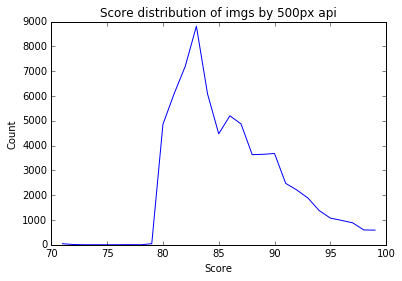

In [9]:
#distribution visualization
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

files = os.listdir('data/')
rate = {}
for file in files:
    if not file.endswith('.jpeg'):
        continue
    score = round(float(file.split('_')[1].split('.jpeg')[0]))
    if score not in rate:
        rate[score] = 0
    rate[score] += 1
    
sd = sorted(rate.items())
X = []
Y = []
for a,b in sd:
    X.append(a)
    Y.append(b)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Score distribution of imgs by 500px api')
plt.plot(X,Y)
plt.savefig('ds.png')
plt.show()

This is a well-rated dataset containing about 74K images from 500px among which 16K pictures with rating scores higher than 90 and 19K pictures whose scores are between 70 and 82.

## Histogram of Oriented Gradient (HOG) 

Since there are too many features for a raw image, i.e. for a 512 * 512 grayscale image, there will be 262144 features. Too many features increase the model complexity, takes computaion resource and trend to overfitting. Thus, the first step processing the image is feature extraction.

We choose HoG ( Histogram of gradients ) to extract the features. Specifically, we choose every 8 * 8 pixels in a winodow as a cell, calculate the number of gradients in each orientation within this cell. Eventually we will obtain a low-demensional vector has all features in the raw image.

<img src="http://scikit-image.org/docs/dev/_images/plot_hog_1.png">

In [10]:
from skimage.feature import hog
from skimage import data, color, exposure

def reshapeVector(filename):
    image = cv2.imread(filename)
    a = np.array(image)
    return a.ravel()

def computeHOG(filename):
    image = cv2.imread(filename,0)
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),
                        cells_per_block=(1, 1), visualise=True)
    return fd

files = os.listdir('data/')

X_all = []
y_all = []

i=0
for file in files:
    i += 1
    if i%10 != 0:
        continue
    if not file.endswith('.jpeg'):
        continue
    sample = 'data/'+file
    score = round(float(file.split('_')[1].split('.jpeg')[0]))
    if score > 82 and score < 90:
        continue
    X_all.append(computeHOG(sample))
    if score >= 90:
        y_all.append(1)
    else:
        y_all.append(-1)

## SVM classifier

The final step in aesthetics pictures classification is to feed the descriptors into some recognition system based on supervised learning. The support vector machine (SVM) classifier is a binary classifier which looks for an optimal hyperplane as a decision function. Once trained on images containing known rating information, the SVM classifier can make decisions based on the HOG descriptors.

We randomly split the original data into 6 parts, use 5/6 data to train SVM model and 1/6 for test. After repeating k times to get different data fot SVM model, we calculate the average test error as final performance.

In [15]:
from sklearn import svm
import math

# filter outlier
X2 = []
y2 = []
for i in range(len(X_all)):
    if len(X_all[i]) > 1:
        X2.append(X_all[i])
        y2.append(y_all[i])

X_list = X2
y_list = y2

data_sample = len(X_list)
print data_sample
k = 3
lin_err = 0
rbf_err = 0
poly_err = 0
for _ in xrange(k):
    perm = np.random.permutation(data_sample)
    perm_train = perm[ round(1.0 / 6.0 * data_sample) :]
    perm_test = perm[: round(1.0/ 6.0 * data_sample)]
    x_train = [X_list[i] for i in perm_train]
    x_test = [X_list[i] for i in perm_test]
    y_train = [y_list[i] for i in perm_train]
    y_test = [y_list[i] for i in perm_test]

    C = 1.0  # SVM regularization parameter
    lin_svc = svm.SVC(kernel='linear', C=C).fit(x_train, y_train)
    rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(x_train, y_train)
    poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(x_train, y_train)

    err_num = np.count_nonzero( lin_svc.predict(x_test) * np.array(y_test) == -1) 
    lin_err += (err_num * 1.0 / len(y_test) )

    err_num = np.count_nonzero( rbf_svc.predict(x_test) * np.array(y_test) == -1) 
    rbf_err += (err_num * 1.0 / len(y_test) )
    
    err_num = np.count_nonzero( poly_svc.predict(x_test) * np.array(y_test) == -1) 
    poly_err += (err_num * 1.0 / len(y_test) )
    
    
print "error using linear kernel: "
print lin_err / k
print "error using rbf kernel: "
print rbf_err / k
print "error using poly kernel: "
print poly_err / k

3362


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


error using linear kernel: 
0.501785714286
error using rbf kernel: 
0.467857142857
error using poly kernel: 
0.467857142857


## HOG result analysis

The svm test result are shown above, where we try different kernel functions but they are not work well. While HoG works excellently in most feature extraction problems, it is noticable that HoG not works well for this problem. HoG features is not meanfull for esathetics classifying. For asethetics evaluation, the feature selection is very hard to obtain through traditional computer vision techniques. 

In next part, we will use a different approach to solve this problem with much high accuracy by builing the deep and intelligent network.